<a href="https://colab.research.google.com/github/miguelvelascop/PFG_Miguel_Velasco_Puig/blob/main/Entrenamiento_Modelos_PGF_DemonicSalmon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt

En este paso se debe elegir el tipo de etiquetas que se quiere usar dependeniendo del preprocesado realizado (primer bloque para etiquetas binarias, segundo bloque para etiquetas originales)

In [2]:
dataFileName = "Dataset_DemonicSalmon_procesado_etiqBinarias.csv"
selectedAverage = 'binary'
labels = [0,1]

In [ ]:
dataFileName = "Dataset_DemonicSalmon_procesado_etiqOriginales.csv"
selectedAverage = 'micro'
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12]

Cargamos el dataset, depresión y no depresión por separado, que previamente he mergeado, ya que estaban separados por pacientes

In [3]:
from google.colab import files
depresjon_data = files.upload()



In [4]:
data=pd.read_csv(dataFileName,  sep=',',  comment='#')


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset_DemonicSalmon_procesado_etiqBinarias.csv'

Pasamos los csv a matrices, quitando los índices


In [ ]:
demonicSalmon_origin = pd.read_csv(dataFileName,  sep=',',  comment='#').to_numpy()


Separamos las etiquetas de los datos

In [ ]:
demonicSalmon_data = demonicSalmon_origin[:, :-1]
demonicSalmon_target = demonicSalmon_origin[:, -1]

print(demonicSalmon_data.size)

7983


Oversampling SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=50)
demonicSalmon_data_resampled, demonicSalmon_target_resampled = smote.fit_resample(demonicSalmon_data, demonicSalmon_target)
print(demonicSalmon_data_resampled.size)

12024



Normalización

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(demonicSalmon_data_resampled)
demonicSalmon_data_resampled_rescaled = scaler.transform(demonicSalmon_data_resampled)

Selección de características por filtros


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=6)

print(demonicSalmon_data_resampled_rescaled.shape)
demonicSalmon_data_resampled_rescaled = selector.fit_transform(demonicSalmon_data_resampled_rescaled, demonicSalmon_target_resampled)
print(selector.get_support(indices=True))
print(selector.scores_)
print(demonicSalmon_data_resampled_rescaled.shape)

(887, 9)
[0 4 5 6 7 8]
[1.67362303e+03 5.54992889e-02 9.67225132e-02 1.01392460e-03
 1.15304656e+00 8.61443145e+00 1.37325306e+00 1.79903813e-01
 1.38551440e+03]
(887, 6)


Separamos los datos en 20/80 para tener un conjunto de entrenamiento y una de prueba

Separación con oversampling

In [ ]:
from sklearn.model_selection import train_test_split
train_demonicSalmon_x, test_demonicSalmon_x, train_demonicSalmon_y, test_demonicSalmon_y = train_test_split(demonicSalmon_data_resampled_rescaled, demonicSalmon_target_resampled, test_size=0.2, random_state=42)

Probamos los modelos, entrenando (fit) 10 veces los clasificadores para obtener una media

Primero importo los modelos que usaremos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neural_network import MLPClassifier as MLP

from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

Selección de parámetros KNN

In [ ]:
parametros = {'n_neighbors':[1, 10]}
knn = KNN()
accuracyKNN = []
precisionKNN = []
recallKNN = []
f1KNN = []
knn = GridSearchCV(knn, parametros)
for i in range(10):
  knn.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultKNN = knn.predict(test_demonicSalmon_x)
  accuracyKNN.append(accuracy_score(resultKNN, test_demonicSalmon_y))
  precisionKNN.append(precision_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))
  recallKNN.append(recall_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))
  f1KNN.append(f1_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))

Entrenamiento KNN

In [ ]:
resultKNN = knn.fit(train_demonicSalmon_x, train_demonicSalmon_y)


Validación KNN

In [ ]:
scoresKNN = cross_val_score(resultKNN, train_demonicSalmon_x, train_demonicSalmon_y, cv=10)
print(scoresKNN)

[0.79439252 0.71028037 0.8317757  0.69158879 0.78504673 0.8317757
 0.71028037 0.76635514 0.73584906 0.81132075]


Matriz de confusión

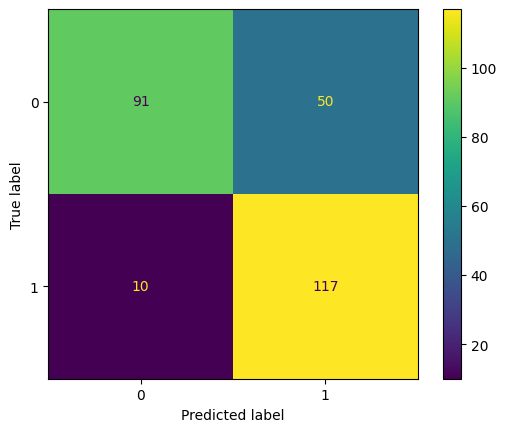

In [ ]:
y_pred = knn.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Clacular média y desviación de KNN

In [ ]:
meanAcKNN = np.median(accuracyKNN)
stdAcKNN=np.std(accuracyKNN)
meanPrKNN = np.median(precisionKNN)
stdPrKNN=np.std(precisionKNN)
meanReKNN = np.median(recallKNN)
stdReKNN=np.std(recallKNN)
meanF1KNN = np.median(f1KNN)
stdF1KNN=np.std(f1KNN)

Selección de parámetros SVC

In [ ]:
parametros = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}
svm = SVC()
accuracySVC = []
precisionSVC = []
recallSVC = []
f1SVC = []
svm = GridSearchCV(svm, parametros)
for i in range(10):
  svm.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultSVC = svm.predict(test_demonicSalmon_x)
  accuracySVC.append(accuracy_score(resultSVC, test_demonicSalmon_y))
  precisionSVC.append(precision_score(resultSVC, test_demonicSalmon_y,average=selectedAverage))
  recallSVC.append(recall_score(resultSVC, test_demonicSalmon_y,average=selectedAverage))
  f1SVC.append(f1_score(resultSVC, test_demonicSalmon_y,average=selectedAverage))

Entrenamiento SVM

In [ ]:
resultSVM = svm.fit(train_demonicSalmon_x, train_demonicSalmon_y)

Validación SVM

In [ ]:
scoresSVM = cross_val_score(resultSVM, train_demonicSalmon_x, train_demonicSalmon_y, cv=10)
print(scoresSVM)

[0.81308411 0.71962617 0.80373832 0.71028037 0.76635514 0.8317757
 0.71028037 0.77570093 0.70754717 0.73584906]


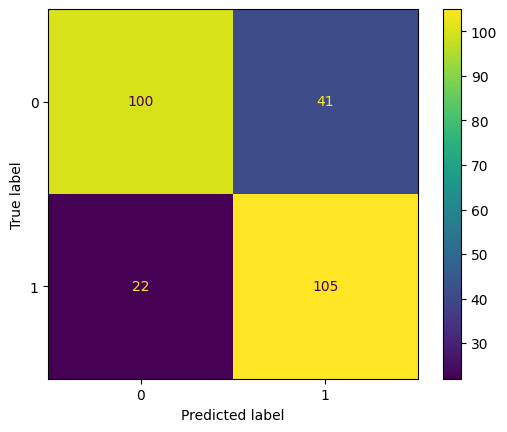

In [ ]:
y_pred = svm.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de SVM

In [ ]:
meanAcSVC = np.median(accuracySVC)
stdAcSVC=np.std(accuracySVC)
meanPrSVC = np.median(precisionSVC)
stdPrSVC=np.std(precisionSVC)
meanReSVC = np.median(recallSVC)
stdReSVC=np.std(recallSVC)
meanF1SVC = np.median(f1SVC)
stdF1SVC=np.std(f1SVC)

Selección de parámetros linearSVM

In [ ]:
parametros = {'loss':('hinge','square_hinge'),'intercept_scaling':[1, 10]}
linearSVM = LinearSVC()
accuracyLinearSVM = []
precisionLinearSVM = []
recallLinearSVM = []
f1LinearSVM = []
linearSVM = GridSearchCV(linearSVM, parametros)
for i in range(10):
  linearSVM.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultLinearSVM = linearSVM.predict(test_demonicSalmon_x)
  accuracyLinearSVM.append(accuracy_score(resultLinearSVM, test_demonicSalmon_y))
  precisionLinearSVM.append(precision_score(resultLinearSVM, test_demonicSalmon_y,average=selectedAverage))
  recallLinearSVM.append(recall_score(resultLinearSVM, test_demonicSalmon_y,average=selectedAverage))
  f1LinearSVM.append(f1_score(resultLinearSVM, test_demonicSalmon_y,average=selectedAverage))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Entrenamiento LinearSVM

In [ ]:
modelSVM = linearSVM.fit(train_demonicSalmon_x, train_demonicSalmon_y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Validación LinearSVC

In [ ]:
scoresLinearSVM = cross_val_score(modelSVM, train_demonicSalmon_x, train_demonicSalmon_y, cv=10)
print(scoresLinearSVM)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[0.57943925 0.61682243 0.56074766 0.54205607 0.57009346 0.61682243
 0.58878505 0.59813084 0.52830189 0.5754717 ]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y

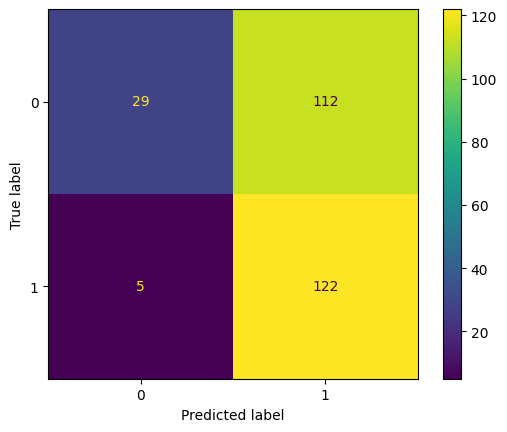

In [ ]:
y_pred = linearSVM.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
meanAcLinearSVM = np.median(accuracyLinearSVM)
stdAcLinearSVM=np.std(accuracyLinearSVM)
meanPrLinearSVM = np.median(precisionLinearSVM)
stdPrLinearSVM=np.std(precisionLinearSVM)
meanReLinearSVM = np.median(recallLinearSVM)
stdReLinearSVM=np.std(recallLinearSVM)
meanF1LinearSVM = np.median(f1LinearSVM)
stdF1LinearSVM=np.std(f1LinearSVM)
print(meanAcLinearSVM, stdAcLinearSVM,meanPrLinearSVM,stdPrLinearSVM,meanReLinearSVM,stdReLinearSVM,meanF1LinearSVM,stdF1LinearSVM)

0.5634328358208955 0.005597014925373134 0.9606299212598425 1.1102230246251565e-16 0.5213675213675214 0.0032721810964488895 0.6759002770083102 0.0027700831024930817


Selección de parámetros GPC

In [ ]:
parametros = {'optimizer':('fmin_l_bfgs_b','callable','None')}
gpc = GPC()
accuracyGPC = []
precisionGPC = []
recallGPC = []
f1GPC = []
gpc = GridSearchCV(gpc, parametros)
for i in range(10):
  gpc.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultGPC = gpc.predict(test_demonicSalmon_x)
  accuracyGPC.append(accuracy_score(resultGPC, test_demonicSalmon_y))
  precisionGPC.append(precision_score(resultGPC, test_demonicSalmon_y, average=selectedAverage))
  recallGPC.append(recall_score(resultGPC, test_demonicSalmon_y, average=selectedAverage))
  f1GPC.append(f1_score(resultGPC, test_demonicSalmon_y, average=selectedAverage))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

Entrenamiento GPC

In [ ]:
modelGPC = gpc.fit(train_demonicSalmon_x, train_demonicSalmon_y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

Validación GPC

In [ ]:
scoresGPC = cross_val_score(modelGPC, train_demonicSalmon_x, train_demonicSalmon_y, cv=10)
print(scoresGPC)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

[0.63551402 0.61682243 0.57943925 0.55140187 0.61682243 0.62616822
 0.61682243 0.51401869 0.47169811 0.56603774]


Matriz de Confusión

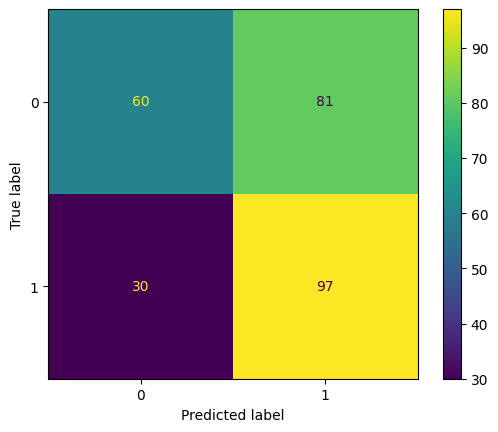

In [ ]:
y_pred = gpc.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de GPC

In [ ]:
meanAcGPC = np.median(accuracyGPC)
stdAcGPC=np.std(accuracyGPC)
meanPrGPC = np.median(precisionGPC)
stdPrGPC=np.std(precisionGPC)
meanReGPC = np.median(recallGPC)
stdReGPC=np.std(recallGPC)
meanF1GPC = np.median(f1GPC)
stdF1GPC=np.std(f1GPC)

Selección de parámetros DTC

In [ ]:
parametros = {'min_samples_split':[1,100],'splitter':('best','random'),'max_features':('auto','sqrt')}
accuracyDTC = []
precisionDTC = []
recallDTC = []
f1DTC = []
dtc = DTC()
dtc = GridSearchCV(dtc, parametros)
for i in range(10):
  dtc.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultDTC = dtc.predict(test_demonicSalmon_x)
  accuracyDTC.append(accuracy_score(resultDTC, test_demonicSalmon_y))
  precisionDTC.append(precision_score(resultDTC, test_demonicSalmon_y, average=selectedAverage))
  recallDTC.append(recall_score(resultDTC, test_demonicSalmon_y, average=selectedAverage))
  f1DTC.append(f1_score(resultDTC, test_demonicSalmon_y, average=selectedAverage))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Entrenamiento DTC

In [ ]:
resultDTC = dtc.fit(train_demonicSalmon_x, train_demonicSalmon_y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Validación DTC

In [ ]:
scoresDTC = cross_val_score(resultDTC, train_demonicSalmon_x, train_demonicSalmon_y, cv=10)
print(scoresDTC)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

[0.6635514  0.64485981 0.80373832 0.61682243 0.61682243 0.68224299
 0.69158879 0.65420561 0.59433962 0.61320755]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Matriz de Confusión

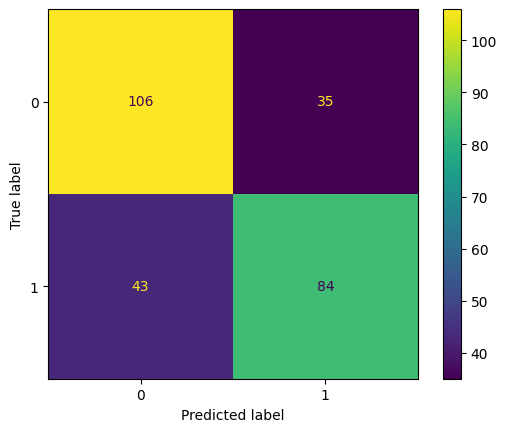

In [ ]:
y_pred = dtc.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de DTC

In [ ]:
meanAcDTC = np.median(accuracyDTC)
stdAcDTC=np.std(accuracyDTC)
meanPrDTC = np.median(precisionDTC)
stdPrDTC=np.std(precisionDTC)
meanReDTC = np.median(recallDTC)
stdReDTC=np.std(recallDTC)
meanF1DTC = np.median(f1DTC)
stdF1DTC=np.std(f1DTC)
print(meanAcDTC, stdAcDTC)

0.7238805970149254 0.026688887674996498


Seleccionar caracteríticas RFC

In [ ]:
parametros = {'criterion':('gini','entropy','log_loss'),'bootstrap':[True, False]}
accuracyRFC = []
precisionRFC = []
recallRFC = []
f1RFC = []
rfc = RFC()
rfc = GridSearchCV(rfc, parametros)
for i in range(10):
  rfc.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultRFC = rfc.predict(test_demonicSalmon_x)
  accuracyRFC.append(accuracy_score(resultRFC, test_demonicSalmon_y))
  precisionRFC.append(precision_score(resultRFC, test_demonicSalmon_y, average=selectedAverage))
  recallRFC.append(recall_score(resultRFC, test_demonicSalmon_y, average=selectedAverage))
  f1RFC.append(f1_score(resultRFC, test_demonicSalmon_y, average=selectedAverage))

Entrenamiento RFC

In [ ]:
resultRFC = rfc.fit(train_demonicSalmon_x, train_demonicSalmon_y)

Validación RFC

In [ ]:
scoresRFC = cross_val_score(resultRFC, test_demonicSalmon_x, test_demonicSalmon_y, cv=10)
print(scoresRFC)

[0.74074074 0.74074074 0.66666667 0.81481481 0.81481481 0.85185185
 0.92592593 0.55555556 0.73076923 0.61538462]


Matriz de Confusión

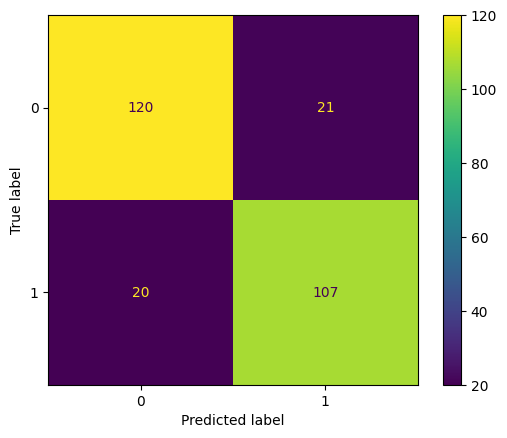

In [ ]:
y_pred = rfc.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de RFC

In [ ]:
meanAcRFC = np.median(accuracyRFC)
stdAcRFC=np.std(accuracyRFC)
meanPrRFC = np.median(precisionRFC)
stdPrRFC=np.std(precisionRFC)
meanReRFC = np.median(recallRFC)
stdReRFC=np.std(recallRFC)
meanF1RFC = np.median(f1RFC)
stdF1RFC=np.std(f1RFC)

Selección de características AdaBoost

In [ ]:
parametros = {'n_estimators':[20, 100],'algorithm':('SAMME', 'SAMME.R'),'learning_rate':[1, 10]}
accuracyABC = []
precisionABC = []
recallABC = []
f1ABC = []
abc = ABC()
abc = GridSearchCV(abc, parametros)
for i in range(10):
  abc.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultABC = abc.predict(test_demonicSalmon_x)
  accuracyABC.append(accuracy_score(resultABC, test_demonicSalmon_y))
  precisionABC.append(precision_score(resultABC, test_demonicSalmon_y, average=selectedAverage))
  recallABC.append(recall_score(resultABC, test_demonicSalmon_y, average=selectedAverage))
  f1ABC.append(f1_score(resultABC, test_demonicSalmon_y, average=selectedAverage))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Entrenamiento AdaBoost

In [ ]:
resultABC = abc.fit(train_demonicSalmon_x, train_demonicSalmon_y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Validación ABC

In [ ]:
scoresABC = cross_val_score(resultABC, test_demonicSalmon_x, test_demonicSalmon_y, cv=10)
print(scoresABC)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[0.77777778 0.81481481 0.62962963 0.74074074 0.55555556 0.74074074
 0.7037037  0.62962963 0.57692308 0.65384615]


Matriz de Confusión

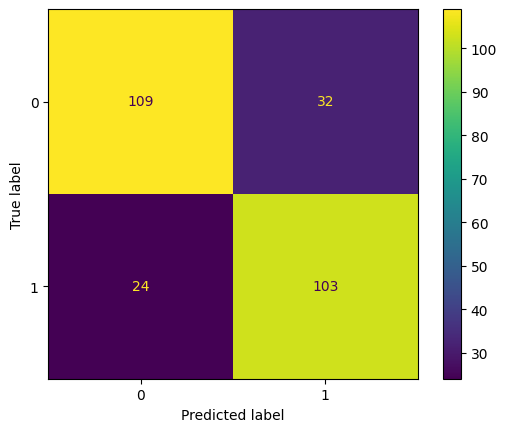

In [ ]:
y_pred = abc.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de ABC

In [ ]:
meanAcABC = np.median(accuracyABC)
stdAcABC=np.std(accuracyABC)
meanPrABC = np.median(precisionABC)
stdPrABC=np.std(precisionABC)
meanReABC = np.median(recallABC)
stdReABC=np.std(recallABC)
meanF1ABC = np.median(f1ABC)
stdF1ABC=np.std(f1ABC)

Selección de parámetros NaiveBayes

In [ ]:
accuracyNB = []
precisionNB = []
recallNB = []
f1NB = []
nb = NB()
for i in range(10):
  nb.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultNB = nb.predict(test_demonicSalmon_x)
  accuracyNB.append(accuracy_score(resultKNN, test_demonicSalmon_y))
  precisionNB.append(precision_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))
  recallNB.append(recall_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))
  f1NB.append(f1_score(resultKNN, test_demonicSalmon_y, average=selectedAverage))

Entrenamiento GaussianNN

In [ ]:
resultNB = nb.fit(train_demonicSalmon_x, train_demonicSalmon_y)

Validación NB

In [ ]:
scoresNB = cross_val_score(resultNB, test_demonicSalmon_x, test_demonicSalmon_y, cv=10)
print(scoresNB)

[0.62962963 0.59259259 0.59259259 0.7037037  0.51851852 0.62962963
 0.62962963 0.66666667 0.69230769 0.42307692]


Matriz de confusión

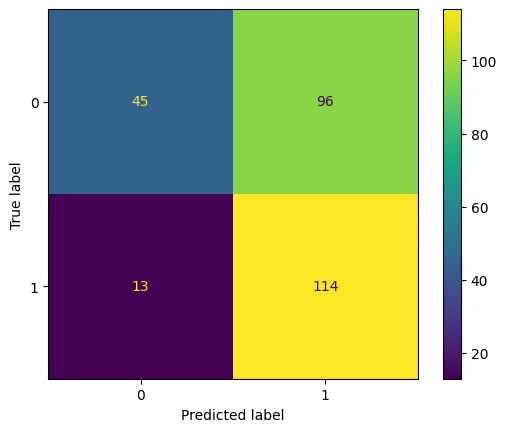

In [ ]:
y_pred = nb.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de NB

In [ ]:
meanAcNB = np.median(accuracyNB)
stdAcNB=np.std(accuracyNB)
meanPrNB = np.median(precisionNB)
stdPrNB=np.std(precisionNB)
meanReNB = np.median(recallNB)
stdReNB=np.std(recallNB)
meanF1NB = np.median(f1NB)
stdF1NB=np.std(f1NB)

Entrenamiento Red Neuronal (MLP)

In [ ]:
mlp = MLP(hidden_layer_sizes=(150,100,50),max_iter=200,activation='relu',solver='adam')
accuracyMLP = []
precisionMLP = []
recallMLP = []
f1MLP = []
for i in range(10):
  mlp.fit(train_demonicSalmon_x, train_demonicSalmon_y)
  resultMLP = mlp.predict(test_demonicSalmon_x)
  accuracyMLP.append(accuracy_score(resultMLP, test_demonicSalmon_y))
  precisionMLP.append(precision_score(resultMLP, test_demonicSalmon_y, average=selectedAverage))
  recallMLP.append(recall_score(resultMLP, test_demonicSalmon_y, average=selectedAverage))
  f1MLP.append(f1_score(resultMLP, test_demonicSalmon_y, average=selectedAverage))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
resultMLP = mlp.fit(train_demonicSalmon_x, train_demonicSalmon_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Validación MLP

In [ ]:
scoresMLP = cross_val_score(resultMLP, test_demonicSalmon_x, test_demonicSalmon_y, cv=10)
print(scoresMLP)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

[0.59259259 0.66666667 0.48148148 0.74074074 0.7037037  0.74074074
 0.85185185 0.66666667 0.69230769 0.53846154]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Matriz de confusión MLP

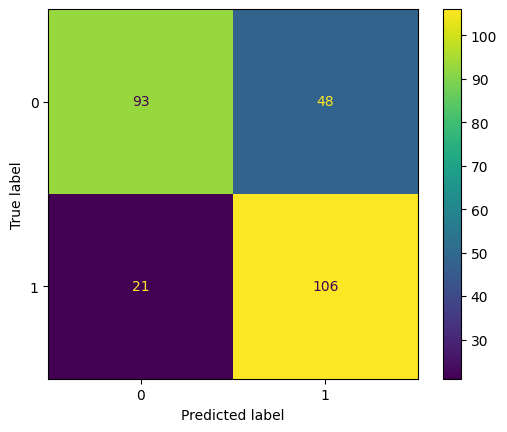

In [ ]:
y_pred = mlp.predict(test_demonicSalmon_x)
cm = confusion_matrix(test_demonicSalmon_y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Média y varianza de MLP

In [ ]:
meanMLP=np.median(accuracyMLP)
stdMLP=np.std(accuracyMLP)
meanAcMLP = np.median(accuracyMLP)
stdAcMLP=np.std(accuracyMLP)
meanPrMLP = np.median(precisionMLP)
stdPrMLP=np.std(precisionMLP)
meanReMLP = np.median(recallMLP)
stdReMLP=np.std(recallMLP)
meanF1MLP = np.median(f1MLP)
stdF1MLP=np.std(f1MLP)
print(meanAcMLP, stdAcMLP)

0.7630597014925373 0.013536087423296303


Ejecutar el siguiente bloque para ver métricas finales

In [ ]:
print("Resultados KNN/ Accuracy: ",meanAcKNN, stdAcKNN, " Precision", meanPrKNN, stdPrKNN, " Recall:", meanReKNN, stdReKNN, " F1:",meanF1KNN, stdF1KNN)
print("Resultados SVM/ Accuracy: ",meanAcSVC, stdAcSVC," Precision",meanPrSVC, stdPrSVC," Recall:",meanReSVC, stdReSVC," F1:",meanF1SVC, stdF1SVC)
print("Resultados LSVM/ Accuracy: ",meanAcLinearSVM, stdAcLinearSVM," Precision",meanPrLinearSVM, stdPrLinearSVM," Recall:",meanReLinearSVM, stdReLinearSVM," F1:",meanF1LinearSVM, stdF1LinearSVM)
print("Resultados GPC/ Accuracy: ",meanAcGPC, stdAcGPC," Precision",meanPrGPC, stdPrGPC," Recall:",meanReGPC, stdReGPC," F1:",meanF1GPC, stdF1GPC)
print("Resultados DTC/ Accuracy: ",meanAcDTC, stdAcDTC," Precision",meanPrDTC, stdPrDTC," Recall:",meanReDTC, stdReDTC," F1:",meanF1DTC, stdF1DTC)
print("Resultados RFC/ Accuracy: ",meanAcRFC, stdAcRFC," Precision",meanPrRFC, stdPrRFC," Recall:",meanReRFC, stdReRFC," F1:",meanF1RFC, stdF1RFC)
print("Resultados AdaBoost/ Accuracy: :",meanAcABC, stdAcABC," Precision",meanPrABC, stdPrABC," Recall:",meanReABC, stdReABC," F1:",meanF1ABC, stdF1ABC)
print("Resultados GaussianNN/ Accuracy: ",meanAcNB, stdAcNB," Precision",meanPrNB, stdPrNB," Recall:",meanReNB, stdReNB," F1:",meanF1NB, stdF1NB)
print("Resultados MLP/ Accuracy: ",meanAcMLP, stdAcMLP," Precision",meanPrMLP, stdPrMLP," Recall:",meanReMLP, stdReMLP," F1:",meanF1MLP, stdF1MLP)

Resultados KNN/ Accuracy:  0.7761194029850746 1.1102230246251565e-16  Precision 0.9212598425196851 1.1102230246251565e-16  Recall: 0.7005988023952096 1.1102230246251565e-16  F1: 0.7959183673469388 0.0
Resultados SVM/ Accuracy:  0.7649253731343284 0.0  Precision 0.8267716535433071 0.0  Recall: 0.7191780821917808 0.0  F1: 0.7692307692307693 0.0
Resultados LSVM/ Accuracy:  0.5634328358208955 0.005597014925373134  Precision 0.9606299212598425 1.1102230246251565e-16  Recall: 0.5213675213675214 0.0032721810964488895  F1: 0.6759002770083102 0.0027700831024930817
Resultados GPC/ Accuracy:  0.585820895522388 0.0  Precision 0.7637795275590551 1.1102230246251565e-16  Recall: 0.5449438202247191 0.0  F1: 0.6360655737704918 0.0
Resultados DTC/ Accuracy:  0.7238805970149254 0.026688887674996498  Precision 0.7716535433070866 0.044010042873959446  Recall: 0.6896912611198325 0.03995711799965688  F1: 0.7096354166666667 0.01575602809077351
Resultados RFC/ Accuracy:  0.8283582089552238 0.008582089552238797